## Data Pipelines - Prefect - Example and Workshop
### Big Data Tools 
#### M.Sc. in Applied Analytics (coterminal course)
Fac. de Ingeniería -  Universidad de la Sabana<br>
Prof.: Hugo Franco, Ph.D.

In [1]:
import os
from prefect import flow, task, get_run_logger
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.use('Agg')  # Usar backend no interactivo para evitar problemas de visualización
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kaggle import KaggleApi
import logging
import time
from functools import wraps
import psycopg2

# Environment setup
os.environ['OMP_NUM_THREADS'] = '1'  # Prevent problems with threading

# Constants
LOCAL_KAGGLE_DIR = './auth'
DOWNLOAD_DIRECTORY = './data'
TARGET_DATASET = 'sushilyeotiwad/wheat-seed-dataset'

# Decorador para manejar conexiones a PostgreSQL
def with_postgresql_connection(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        conn = psycopg2.connect(
            host="localhost",
            port=5433,
            database="bigdatatools1",
            user="psqluser",
            password="psqlpass"
        )
        try:
            cur = conn.cursor()
            result = func(cur, *args, **kwargs)
            conn.commit()
            return result
        except Exception as e:
            conn.rollback()
            raise e
        finally:
            cur.close()
            conn.close()
    return wrapper

# Timing decorator to report task duration
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Task '{func.__name__}' took {duration:.4f} seconds")
        return result
    return wrapper

# Helper functions
def get_directory_size(path='.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def format_size(size_bytes):
    """Convierte bytes en una unidad legible (KB, MB, GB)."""
    if size_bytes < 1024:
        return f"{size_bytes} B"
    elif size_bytes < 1024**2:
        return f"{size_bytes / 1024:.2f} KB"
    elif size_bytes < 1024**3:
        return f"{size_bytes / (1024**2):.2f} MB"
    else:
        return f"{size_bytes / (1024**3):.2f} GB"


# Task: Create download directory
@task(name="Create Download Directory")
@timing_decorator
def create_download_directory():
    logger = get_run_logger()
    try:
        if not os.path.exists(DOWNLOAD_DIRECTORY):
            logger.info(f"Creating directory: {DOWNLOAD_DIRECTORY}")
            os.makedirs(DOWNLOAD_DIRECTORY)
        else:
            logger.info(f"Directory {DOWNLOAD_DIRECTORY} already exists.")
    except Exception as e:
        logger.error(f"Failed to create directory {DOWNLOAD_DIRECTORY}: {str(e)}")
        raise
    finally:
        logger.info("Directory creation task completed.")

# Task: Authenticate with Kaggle
@task(retries=3, retry_delay_seconds=10, name="Authenticate")
@timing_decorator
def api_authenticate():
    logger = get_run_logger()
    try:
        logger.info("Attempting Kaggle API authentication...")
        api = KaggleApi()
        api.authenticate()
        logger.info("Kaggle API authentication successful.")
        return api
    except Exception as e:
        logger.error(f"Kaggle authentication failed: {str(e)}")
        raise
    finally:
        logger.info("Authentication task completed.")

def report_download_size(path='.'):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            logger = get_run_logger()
            result = func(*args, **kwargs)
            size_bytes = get_directory_size(path)
            logger.info(f"✅ Dataset downloaded. Total size in '{path}': "
                  f"{size_bytes:,} bytes ({format_size(size_bytes)})")
            return result
        return wrapper
    return decorator
# Task: Download dataset from Kaggle
@report_download_size(DOWNLOAD_DIRECTORY)
@task(retries=3, retry_delay_seconds=10, name="Download Dataset")
@timing_decorator
def download_dataset(kaggle_api):
    logger = get_run_logger()
    try:
        logger.info(f"Downloading dataset '{TARGET_DATASET}' to '{DOWNLOAD_DIRECTORY}'...")
        kaggle_api.dataset_download_files(TARGET_DATASET, path=DOWNLOAD_DIRECTORY, unzip=True)
        logger.info("Dataset download and unzip completed successfully.")
    except Exception as e:
        logger.error(f"Dataset download failed: {str(e)}")
        raise
    finally:
        logger.info("Download task completed.")

# Task: Load CSV into DataFrame
@task(name="Load CSV")
@timing_decorator
def load_csv():
    logger = get_run_logger()
    try:
        os.chdir(DOWNLOAD_DIRECTORY)
        logger.info(f"Loading CSV file from {DOWNLOAD_DIRECTORY}/seeds_dataset.csv")
        df_seeds = pd.read_csv('seeds_dataset.csv')
        logger.info("CSV file loaded successfully.")
        return df_seeds
    except FileNotFoundError as e:
        logger.error(f"CSV file not found: {str(e)}")
        raise
    except Exception as e:
        logger.error(f"Error loading CSV: {str(e)}")
        raise
    finally:
        logger.info("CSV loading task completed.")

# Task: Transform data (cleansing)
@task(name="Transform Data")
@timing_decorator
def transform_data(df_seeds):
    logger = get_run_logger()
    try:
        logger.info("Performing data cleansing...")
        # Basic data cleansing: Drop the 'Class' column
        df_clustering = df_seeds.drop('Class_(1, 2, 3)', axis=1)
        # Additional cleansing: Handle missing values and duplicates
        df_clustering = df_clustering.dropna().drop_duplicates()
        logger.info("Data cleansing completed.")
        return df_clustering
    except KeyError as e:
        logger.error(f"Column not found during transformation: {str(e)}")
        raise
    except Exception as e:
        logger.error(f"Transformation failed: {str(e)}")
        raise
    finally:
        logger.info("Data transformation task completed.")

# Task: Load data into PostgreSQL
@task(name="Load Data to PostgreSQL")
@timing_decorator
@with_postgresql_connection
def load_data(cur, df_clustering):
    logger = get_run_logger()
    try:
        # Create table if it doesn't exist
        logger.info("Creating table if not exists...")
        create_table_query = """
        CREATE TABLE IF NOT EXISTS wheat_seeds_clustering (
            id SERIAL PRIMARY KEY,
            area REAL,
            perimeter REAL,
            compactness REAL,
            length_of_kernel REAL,
            width_of_kernel REAL,
            asymmetry_coefficient REAL,
            length_of_kernel_groove REAL
        )
        """
        cur.execute(create_table_query)
        logger.info("Table created/verified successfully.")
        
        # Insert data from DataFrame
        logger.info("Inserting data into PostgreSQL...")
        for _, row in df_clustering.iterrows():
            insert_query = """
            INSERT INTO wheat_seeds_clustering 
            (area, perimeter, compactness, length_of_kernel, width_of_kernel, asymmetry_coefficient, length_of_kernel_groove)
            VALUES (%s, %s, %s, %s, %s, %s, %s)
            """
            cur.execute(insert_query, tuple(row))
        
        logger.info(f"Successfully inserted {len(df_clustering)} records into PostgreSQL.")
        
    except Exception as e:
        logger.error(f"Error loading data to PostgreSQL: {str(e)}")
        raise

# NEW TASK: Analyze correlations
@task(name="Analyze Correlations")
@timing_decorator
def analyze_correlations(df_clustering):
    logger = get_run_logger()
    try:
        logger.info("Analyzing feature correlations...")
        
        # Calculate the correlation matrix
        correlation_matrix = df_clustering.corr()

        # Find the pair of variables with the lowest absolute correlation
        lower_triangle = correlation_matrix.mask(np.triu(np.ones(correlation_matrix.shape)).astype(bool))
        lowest_corr = lower_triangle.stack().abs().min()
        lowest_corr_pair = lower_triangle.stack().abs().idxmin()

        # Print the lowest correlation and the corresponding pair of variables
        logger.info(f"The lowest absolute correlation is {lowest_corr:.4f}, between {lowest_corr_pair}")

        # Plot a heatmap of the correlation matrix for visualization
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix of Seed Features')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('correlation_heatmap.png')
        plt.close()  # Close the plot to avoid display issues in workflow
        
        logger.info("Correlation analysis completed and heatmap saved.")
        
        return lowest_corr_pair
        
    except Exception as e:
        logger.error(f"Error in correlation analysis: {str(e)}")
        raise

# NEW TASK: Perform clustering with centroids
@task(name="Perform KMeans Clustering with Centroids")
@timing_decorator
def perform_kmeans_clustering(df_clustering, optimal_k=3):
    logger = get_run_logger()
    try:
        logger.info("Performing K-means clustering with centroids...")
        
        # Variables para clustering
        X = df_clustering[['Asymmetry_coefficient', 'Length_of_kernel_groove']]

        # Entrenar KMeans con K óptimo
        kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        df_clustering['cluster'] = kmeans_model.fit_predict(X)

        # Centroides
        centroids = kmeans_model.cluster_centers_

        # Visualizar resultados con centroides
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            df_clustering['Asymmetry_coefficient'], 
            df_clustering['Length_of_kernel_groove'], 
            c=df_clustering['cluster'], cmap='viridis'
        )
        plt.scatter(
            centroids[:, 0], centroids[:, 1], 
            c='red', marker='X', s=200, label='Centroids'
        )
        plt.title(f'K-means Clustering of Seeds (K={optimal_k})')
        plt.xlabel('Asymmetry_coefficient')
        plt.ylabel('Length_of_kernel_groove')
        plt.legend(*scatter.legend_elements(), title="Clusters")
        plt.legend()
        plt.grid(True)
        plt.savefig('kmeans_clustering_with_centroids.png')
        plt.close()  # Close the plot to avoid display issues in workflow

        logger.info("Clustering with centroids completed and visualization saved.")
        
        return df_clustering, centroids
        
    except Exception as e:
        logger.error(f"Error in clustering with centroids: {str(e)}")
        raise

# Main Flow: Orchestrate the pipeline
@flow(name="Wheat Seed Analysis Pipeline")
@report_download_size(DOWNLOAD_DIRECTORY)
def complete_analysis_pipeline():
    create_download_directory()
    kaggle_api = api_authenticate()
    download_dataset(kaggle_api)
    df_seeds = load_csv()
    df_clustering = transform_data(df_seeds)
    load_data(df_clustering)
    lowest_corr_pair = analyze_correlations(df_clustering)
    df_clustered, centroids = perform_kmeans_clustering(df_clustering, optimal_k=3)
    
    return df_clustered, lowest_corr_pair, centroids

# Run the flow
if __name__ == "__main__":
    df_clustered, lowest_corr_pair, centroids = complete_analysis_pipeline()
    print(f"Analysis completed. Lowest correlation pair: {lowest_corr_pair}")
    print(f"Cluster centroids: {centroids}")

11:43:18.613 | INFO    | prefect - Starting temporary server on http://127.0.0.1:8041
See https://docs.prefect.io/v3/concepts/server#how-to-guides for more information on running a dedicated Prefect server.

11:43:21.884 | INFO    | Flow run 'keen-oriole' - Beginning flow run 'keen-oriole' for flow 'Wheat Seed Analysis Pipeline'

11:43:21.909 | INFO    | Task run 'Create Download Directory-790' - Directory ./data already exists.

11:43:21.911 | INFO    | Task run 'Create Download Directory-790' - Directory creation task completed.

Task 'create_download_directory' took 0.0025 seconds


11:43:21.914 | INFO    | Task run 'Create Download Directory-790' - Finished in state Completed()

11:43:21.929 | INFO    | Task run 'Authenticate-fc1' - Attempting Kaggle API authentication...

11:43:21.931 | INFO    | Task run 'Authenticate-fc1' - Kaggle API authentication successful.

11:43:21.932 | INFO    | Task run 'Authenticate-fc1' - Authentication task completed.

Task 'api_authenticate' took 0.0040 seconds


11:43:21.935 | INFO    | Task run 'Authenticate-fc1' - Finished in state Completed()

11:43:21.952 | INFO    | Task run 'Download Dataset-2bc' - Downloading dataset 'sushilyeotiwad/wheat-seed-dataset' to './data'...

Dataset URL: https://www.kaggle.com/datasets/sushilyeotiwad/wheat-seed-dataset


11:43:22.449 | INFO    | Task run 'Download Dataset-2bc' - Dataset download and unzip completed successfully.

11:43:22.450 | INFO    | Task run 'Download Dataset-2bc' - Download task completed.

Task 'download_dataset' took 0.5001 seconds


11:43:22.453 | INFO    | Task run 'Download Dataset-2bc' - Finished in state Completed()

11:43:22.455 | INFO    | Flow run 'keen-oriole' - ✅ Dataset downloaded. Total size in './data': 412,656 bytes (402.98 KB)

11:43:22.466 | INFO    | Task run 'Load CSV-9fd' - Loading CSV file from ./data/seeds_dataset.csv

11:43:22.481 | INFO    | Task run 'Load CSV-9fd' - CSV file loaded successfully.

11:43:22.483 | INFO    | Task run 'Load CSV-9fd' - CSV loading task completed.

Task 'load_csv' took 0.0186 seconds


11:43:22.486 | INFO    | Task run 'Load CSV-9fd' - Finished in state Completed()

11:43:22.500 | INFO    | Task run 'Transform Data-755' - Performing data cleansing...

11:43:22.502 | INFO    | Task run 'Transform Data-755' - Data cleansing completed.

11:43:22.503 | INFO    | Task run 'Transform Data-755' - Data transformation task completed.

Task 'transform_data' took 0.0051 seconds


11:43:22.507 | INFO    | Task run 'Transform Data-755' - Finished in state Completed()

11:43:22.584 | INFO    | Task run 'Load Data to PostgreSQL-fa2' - Creating table if not exists...

11:43:22.586 | INFO    | Task run 'Load Data to PostgreSQL-fa2' - Table created/verified successfully.

11:43:22.587 | INFO    | Task run 'Load Data to PostgreSQL-fa2' - Inserting data into PostgreSQL...

11:43:22.677 | INFO    | Task run 'Load Data to PostgreSQL-fa2' - Successfully inserted 210 records into PostgreSQL.

Task 'load_data' took 0.1582 seconds


11:43:22.682 | INFO    | Task run 'Load Data to PostgreSQL-fa2' - Finished in state Completed()

11:43:22.696 | INFO    | Task run 'Analyze Correlations-eb1' - Analyzing feature correlations...

11:43:22.700 | INFO    | Task run 'Analyze Correlations-eb1' - The lowest absolute correlation is 0.0111, between ('Length_of_kernel_groove', 'Asymmetry_coefficient')

11:43:22.873 | INFO    | Task run 'Analyze Correlations-eb1' - Correlation analysis completed and heatmap saved.

Task 'analyze_correlations' took 0.1785 seconds


11:43:22.876 | INFO    | Task run 'Analyze Correlations-eb1' - Finished in state Completed()

11:43:22.889 | INFO    | Task run 'Perform KMeans Clustering with Centroids-9b4' - Performing K-means clustering with centroids...

c:\ProgramData\miniconda3\envs\bigdata\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


11:43:23.103 | INFO    | Task run 'Perform KMeans Clustering with Centroids-9b4' - Clustering with centroids completed and visualization saved.

Task 'perform_kmeans_clustering' took 0.2152 seconds


11:43:23.107 | INFO    | Task run 'Perform KMeans Clustering with Centroids-9b4' - Finished in state Completed()

11:43:23.109 | INFO    | Flow run 'keen-oriole' - ✅ Dataset downloaded. Total size in './data': 206,328 bytes (201.49 KB)

11:43:23.122 | INFO    | Flow run 'keen-oriole' - Finished in state Completed()

Analysis completed. Lowest correlation pair: ('Length_of_kernel_groove', 'Asymmetry_coefficient')
Cluster centroids: [[5.60078947 5.34238596]
 [3.71363218 5.52770115]
 [2.04107879 5.30710606]]


### Basic (Unsupervised) Machine Learning analytics method
 Determine, by clustering, a sound number of species within the wheat seed dataset

 Firstly, identify the less correlated pair of features and use them as the representation for the instances in the dataset

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# # Calculate the correlation matrix.
# correlation_matrix = df_clustering.corr()

# # Find the pair of variables with the lowest absolute correlation.
# # We take the upper triangle of the correlation matrix and flatten it, and ignore the diagonal (which are all 1).
# # We then find the minimum value and the corresponding row and column.
# lower_triangle = correlation_matrix.mask(np.triu(np.ones(correlation_matrix.shape)).astype(bool))
# lowest_corr = lower_triangle.stack().abs().min()
# lowest_corr_pair = lower_triangle.stack().abs().idxmin()

# # Print the lowest correlation and the corresponding pair of variables.
# print(f"The lowest absolute correlation is {lowest_corr:.4f}, between {lowest_corr_pair}")

# # Plot a heatmap of the correlation matrix for visualization.
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix of Seed Features')
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.savefig('correlation_heatmap.png')
# plt.show()

NameError: name 'df_clustering' is not defined

Now, use the `KMeans` clustering method to perform an unsupervised approach to the identification of the number of species in the dataset, according to the observations 

c:\ProgramData\anaconda3\envs\BigData\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\BigData\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\BigData\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\envs\BigData\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarn

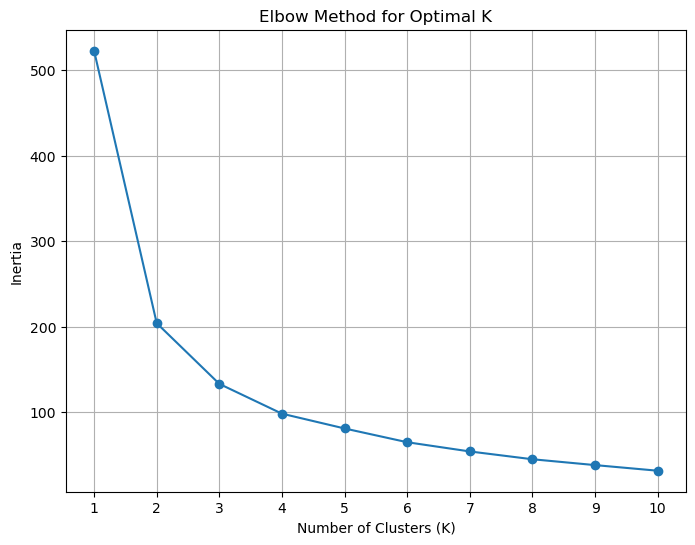

c:\ProgramData\anaconda3\envs\BigData\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


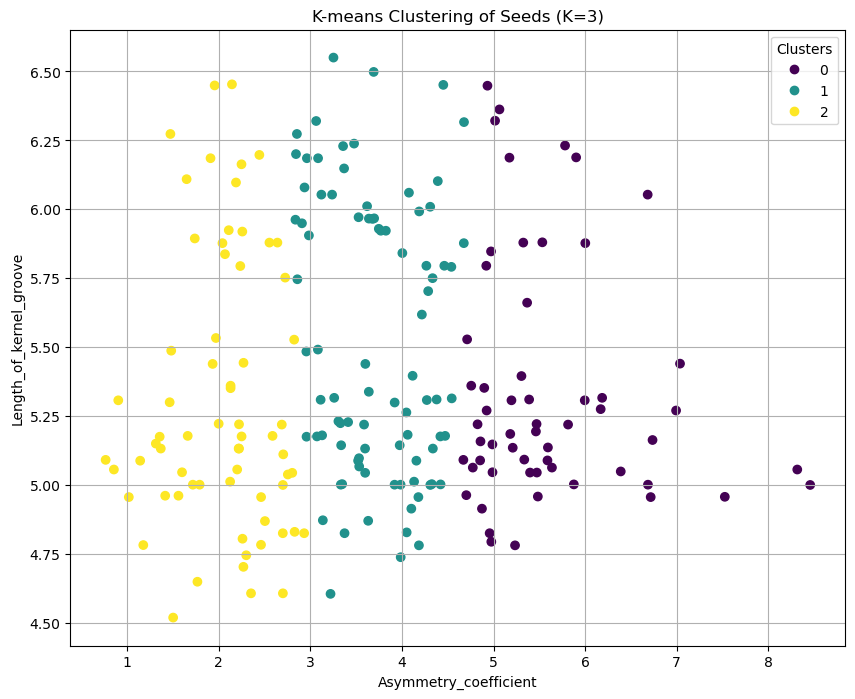

In [ ]:
# from sklearn.cluster import KMeans
# # Select the two variables for clustering.
# X = df_clustering[['Asymmetry_coefficient', 'Length_of_kernel_groove']]

# # Determine the optimal number of clusters using the Elbow Method.
# inertia = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
#     kmeans.fit(X)
#     inertia.append(kmeans.inertia_)

# # Plot the Elbow Method results.
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, 11), inertia, marker='o')
# plt.title('Elbow Method for Optimal K')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Inertia')
# plt.xticks(range(1, 11))
# plt.grid(True)
# plt.savefig('elbow_method.png')
# plt.show()

# # Based on the Elbow plot, choose the optimal number of clusters.
# # For this dataset, the 'Class' column suggests ?? classes, and the elbow method plot shows a good elbow at k=??.
# optimal_k = 3

# # Perform K-means clustering with the optimal number of clusters.
# kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# df_clustering['cluster'] = kmeans_model.fit_predict(X)

# # Visualize the clustering results.
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(df_clustering['Asymmetry_coefficient'], df_clustering['Length_of_kernel_groove'], c=df_clustering['cluster'], cmap='viridis')
# plt.title('K-means Clustering of Seeds (K=3)')
# plt.xlabel('Asymmetry_coefficient')
# plt.ylabel('Length_of_kernel_groove')
# plt.legend(*scatter.legend_elements(), title="Clusters")
# plt.grid(True)
# plt.savefig('kmeans_clustering_plot.png')
# plt.show()



__Challenges (Workshop 3, part 2):__
1. Organize the code of the example and complete the data pipeline: 
    - Use `try-except-finally` blocks as required 
    - Every individual process must be wrapped as a `task` using the corresponding decorator and its parameters when necessary. 
    - Create a `transform_data` task focused on data cleansing
    - Create a `load_data` task to create a table in a Dockerized PostgreSQL database and populate with with the clustering-oriented Dataframe
    - Invoke the tasks in the proper order in the `flow`
    - Use the `timing_decorator` to report the duration of each task 
1. Using the function get_directory_size, create a decorator to get and report the size of the downloaded dataset (size in bytes of the download folder)
1. Report the size in the previous question in a human readable unit
1. Use the attribute kmeans.cluster_centers_ and scatter plot to add the centroids of the best KMeans model (best K parameter) to the scatter plot
    - `centroids = kmeans.cluster_centers_`
